# Evaluation - Notebook

Within this document, we carry out an assessment of the implemented models. Furthermore, hyperparameter optimization is executed for each model wherever feasible. The following models are subjected to evaluation:

1. Moving Average
2. Various variants of linear regression
3. Neural Network
4. XGBoost
5. LSTM

For a more detailed description of the models, please refer to their corresponding section.

In [1]:
# TODO: look into pipeline framework for hyperparameter tuning
# ###: 1. look into warning for large window sizes
# ###: 2. polynomial features for linear regression 
# ###: 3. Different Features (difficult) -> solution might be time-series split
#                                        -> solution: power set of features and normal hyperparameter tuning
# TODO: User can choose which data set and which turbine to use
# TODO: try the transfer learning approach
# TODO: Plotting
# TODO: implement more models
# TODO: implement command line interface - optional 
# TODO: implement logging - optional
# TODO: Documentation 
# TODO: Hand-in

### Author: Harald Kugler

In [2]:
### imports
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

import sys

sys.path.append("..")
sys.path.append("../src")

from src.DataHandling.loading import load_data  # loading
import src.DataHandling.visualization as vis  # plotting
from src.Models.selection import GridSearch  # hyperparameter tuning

### models
from src.Models.ma import MovingAverage
from src.Models.lr import Regression

### Transformers
from src.DataHandling.preprocessing import (
    DataCleaner,
    SupervisedTransformer,
    Normalizer,
    train_test_split,
)

Prior to the assessment of the models, we have to make a few considerations regarding related to the data:

We decide to leverage the pipeline framework provided by sklearn (QUELLE). This enhances the convenience of tasks such as hyperparameter optimization and effectively utilizing the models. Consequently, all data transformations tailored to this project have been developed in a manner consistent with the transformers found in sklearn.preprocessing. Overall, three specific transformers where implemented.

To begin with, it's essential to note that we are working with time series data which implies the need for transformations in order for supervised learning models (e.g. linear regression) to yield meaningful results. 

In the following you can set the ID of the turbine you want to analyze for each dataset. Be aware that benchmarks are only provided for the second turbine within the Kelmarsh data set and the first in the Beberine data set.

In [3]:
### set global variables here ###
TURBINE_ID_BRITISH = 2
TURBINE_ID_BRAZILIAN = 1

In [4]:
# load data
data_brit = load_data(turbine_id=TURBINE_ID_BRITISH, which_data="British")
data_braz = load_data(turbine_id=TURBINE_ID_BRAZILIAN, which_data="Brazilian")

cleaner = DataCleaner(
    features=["Power (kW)", "Wind speed (m/s)"],
    rename_features=["power", "wind_speed"],
)
turbine_brit = cleaner.transform(data_brit)

cleaner = DataCleaner(
    features=["active_power_total", "wind_speed"],
    rename_features=["power", "wind_speed"],
)
turbine_braz = cleaner.transform(data_braz)
turbine_brit.shape, turbine_braz.shape

((286187, 2), (52560, 2))

For understandibility.... models do transformation to a supervised learning problem inherently...

In [5]:
benchmarks = pd.read_csv("../results_wind.csv")
test_start = benchmarks["test_start"][0]
test_end = benchmarks["test_end"][0]

X_train, y_train, X_test, y_test = train_test_split(
    df=turbine_brit, test_start=test_start, test_end=test_end, target_var="power"
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((233627, 2), (233627,), (52560, 2), (52560,))

Before, we begin blablabla ... there are shared parameters across models like window_size etc.

In [6]:
# set up parameters that are the same for all models
param_grid = {
    "st__window_size": [1, 5, 10],
    "st__horizon": [1, 6, 144],
}

## 1. Moving Average

**Explanation of the Model:** 

In contrast to the Baseline model, the Moving Average model offers the flexibility of selecting a window size. This window size determines the number of preceding time steps taken into account for generating forecasts. Furthermore, there is an option to specify a discount factor (default = 1), which regulates the extent of reduction in influence for more distant past time steps. This strategy is similar to how a discount factor is used in calculating future rewards within the framework of reinforcement learning. Note that when a window size of one is chosen, the Moving Average model is identical with the Baseline model.

In [7]:
ma_pipe = Pipeline(
    [
        ("st", SupervisedTransformer()),
        ("Model", MovingAverage()),
    ]
)

param_grid["Model__discount"] = np.linspace(0.5, 1., 3)

grid_search_ma = GridSearch(ma_pipe, param_grid)
grid_search_ma.fit(X_train, y_train, X_test, y_test)

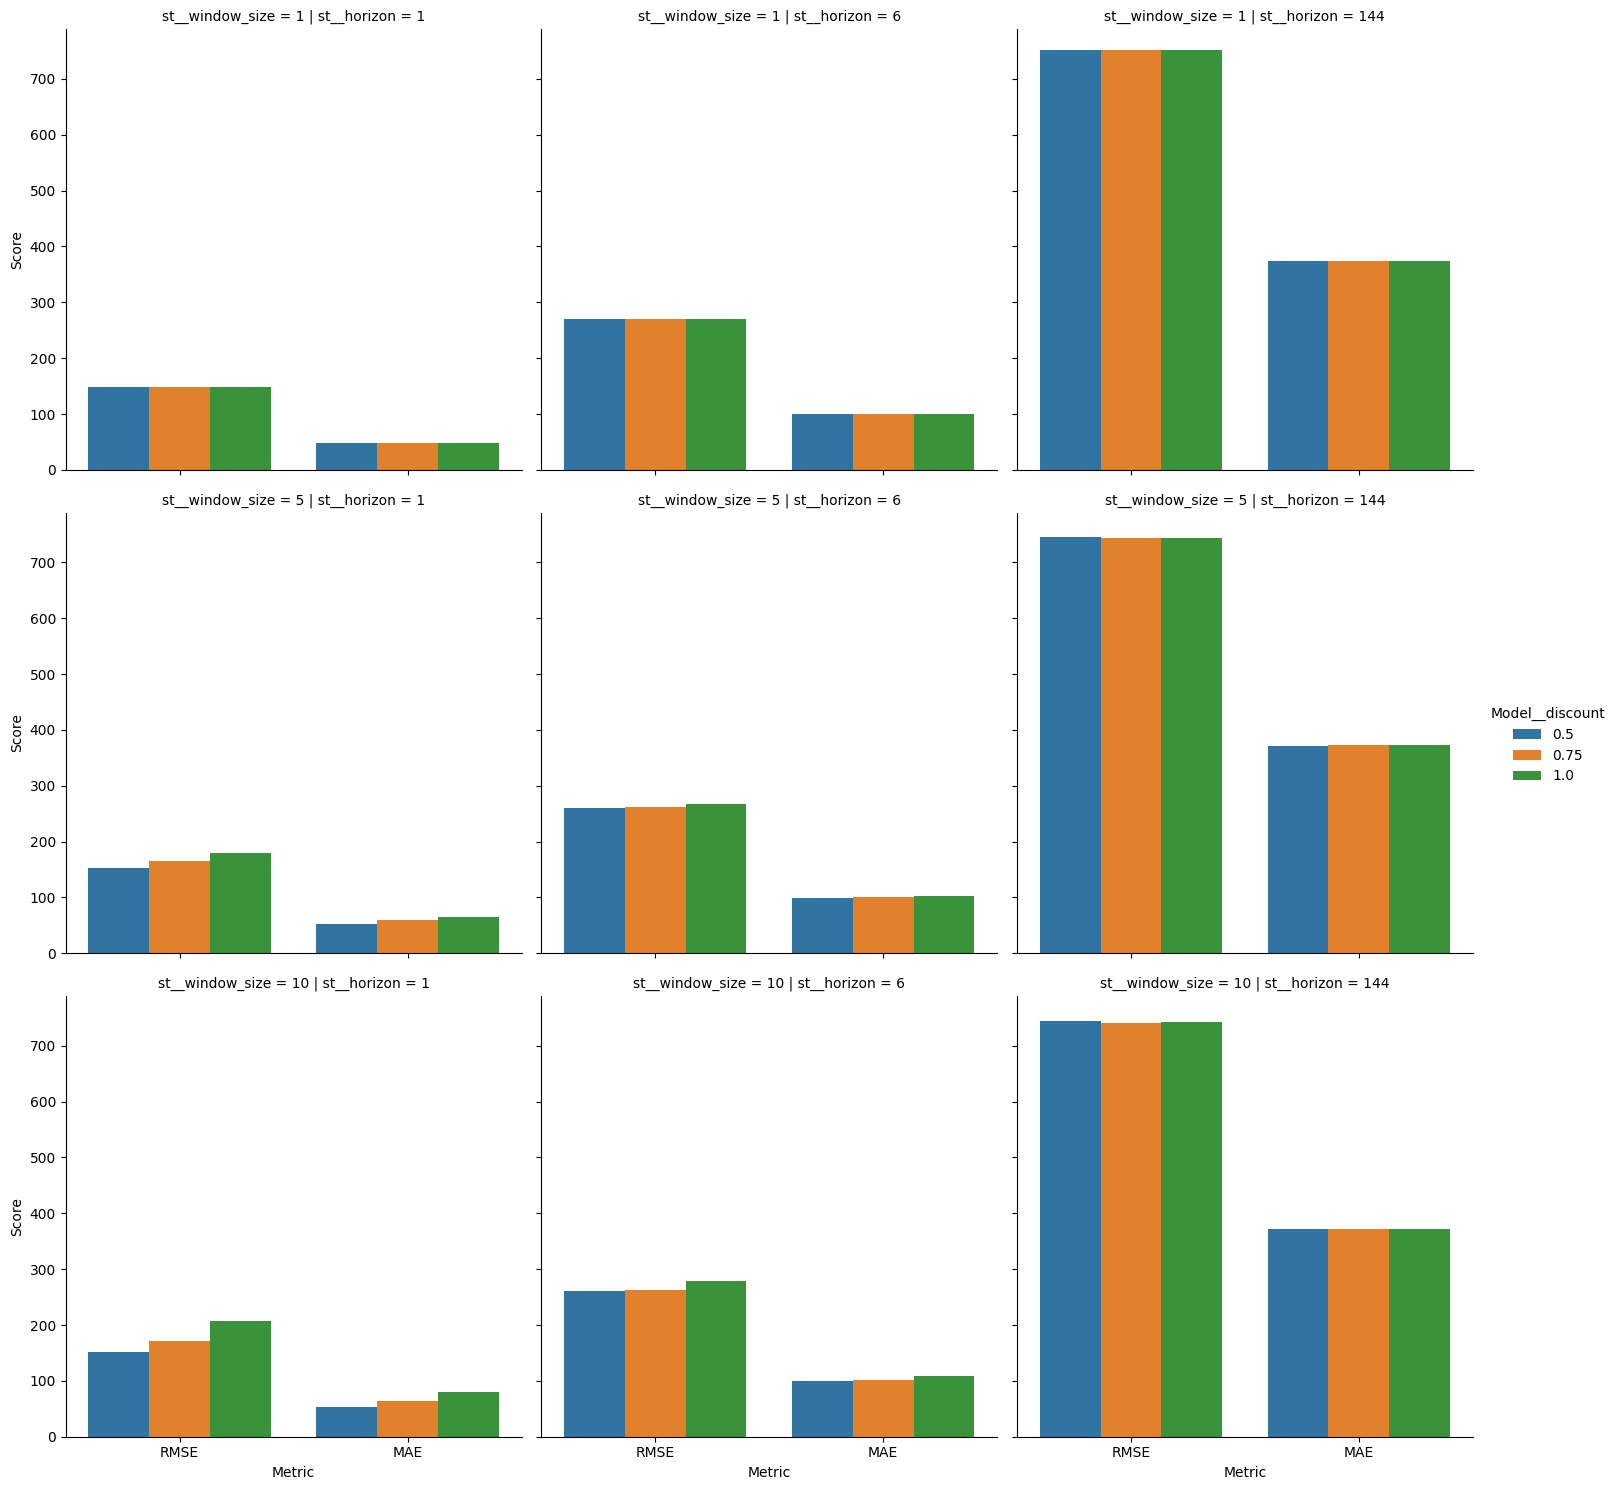

In [8]:
vis.plot_gridsearch(results_df = grid_search_ma.results, hue = "Model__discount", col="st__horizon", row="st__window_size")



**Analysis:**

In [9]:
grid_search_ma.best_models

[Pipeline(steps=[('st', SupervisedTransformer()),
                 ('Model', MovingAverage(discount=0.5))]),
 Pipeline(steps=[('st', SupervisedTransformer(horizon=6, window_size=10)),
                 ('Model', MovingAverage(discount=0.5))]),
 Pipeline(steps=[('st', SupervisedTransformer(horizon=144, window_size=10)),
                 ('Model', MovingAverage(discount=0.75))])]

In [10]:
# delete key of param_grid that is specific to the model
del param_grid["Model__discount"]
param_grid

{'st__window_size': [1, 5, 10], 'st__horizon': [1, 6, 144]}

## 2. Various variants of Linear Regression

**Explanation of the Models:**

1. Linear Regression:
2. Ridge Regression:
3. Lasso Regression:
4. Remarks to Kernel Regression:


In [11]:
lr_pipe = Pipeline(
    [
        ("normalizer", Normalizer()),
        ("st", SupervisedTransformer()),
        ("Model", Regression()),
    ]
)

param_grid["Model__model"] = ["linear", "ridge"]
param_grid["Model__alpha"] = np.logspace(-3, 1, 5)

grid_search_lr = GridSearch(lr_pipe, param_grid)
grid_search_lr.fit(X_train, y_train, X_test, y_test)

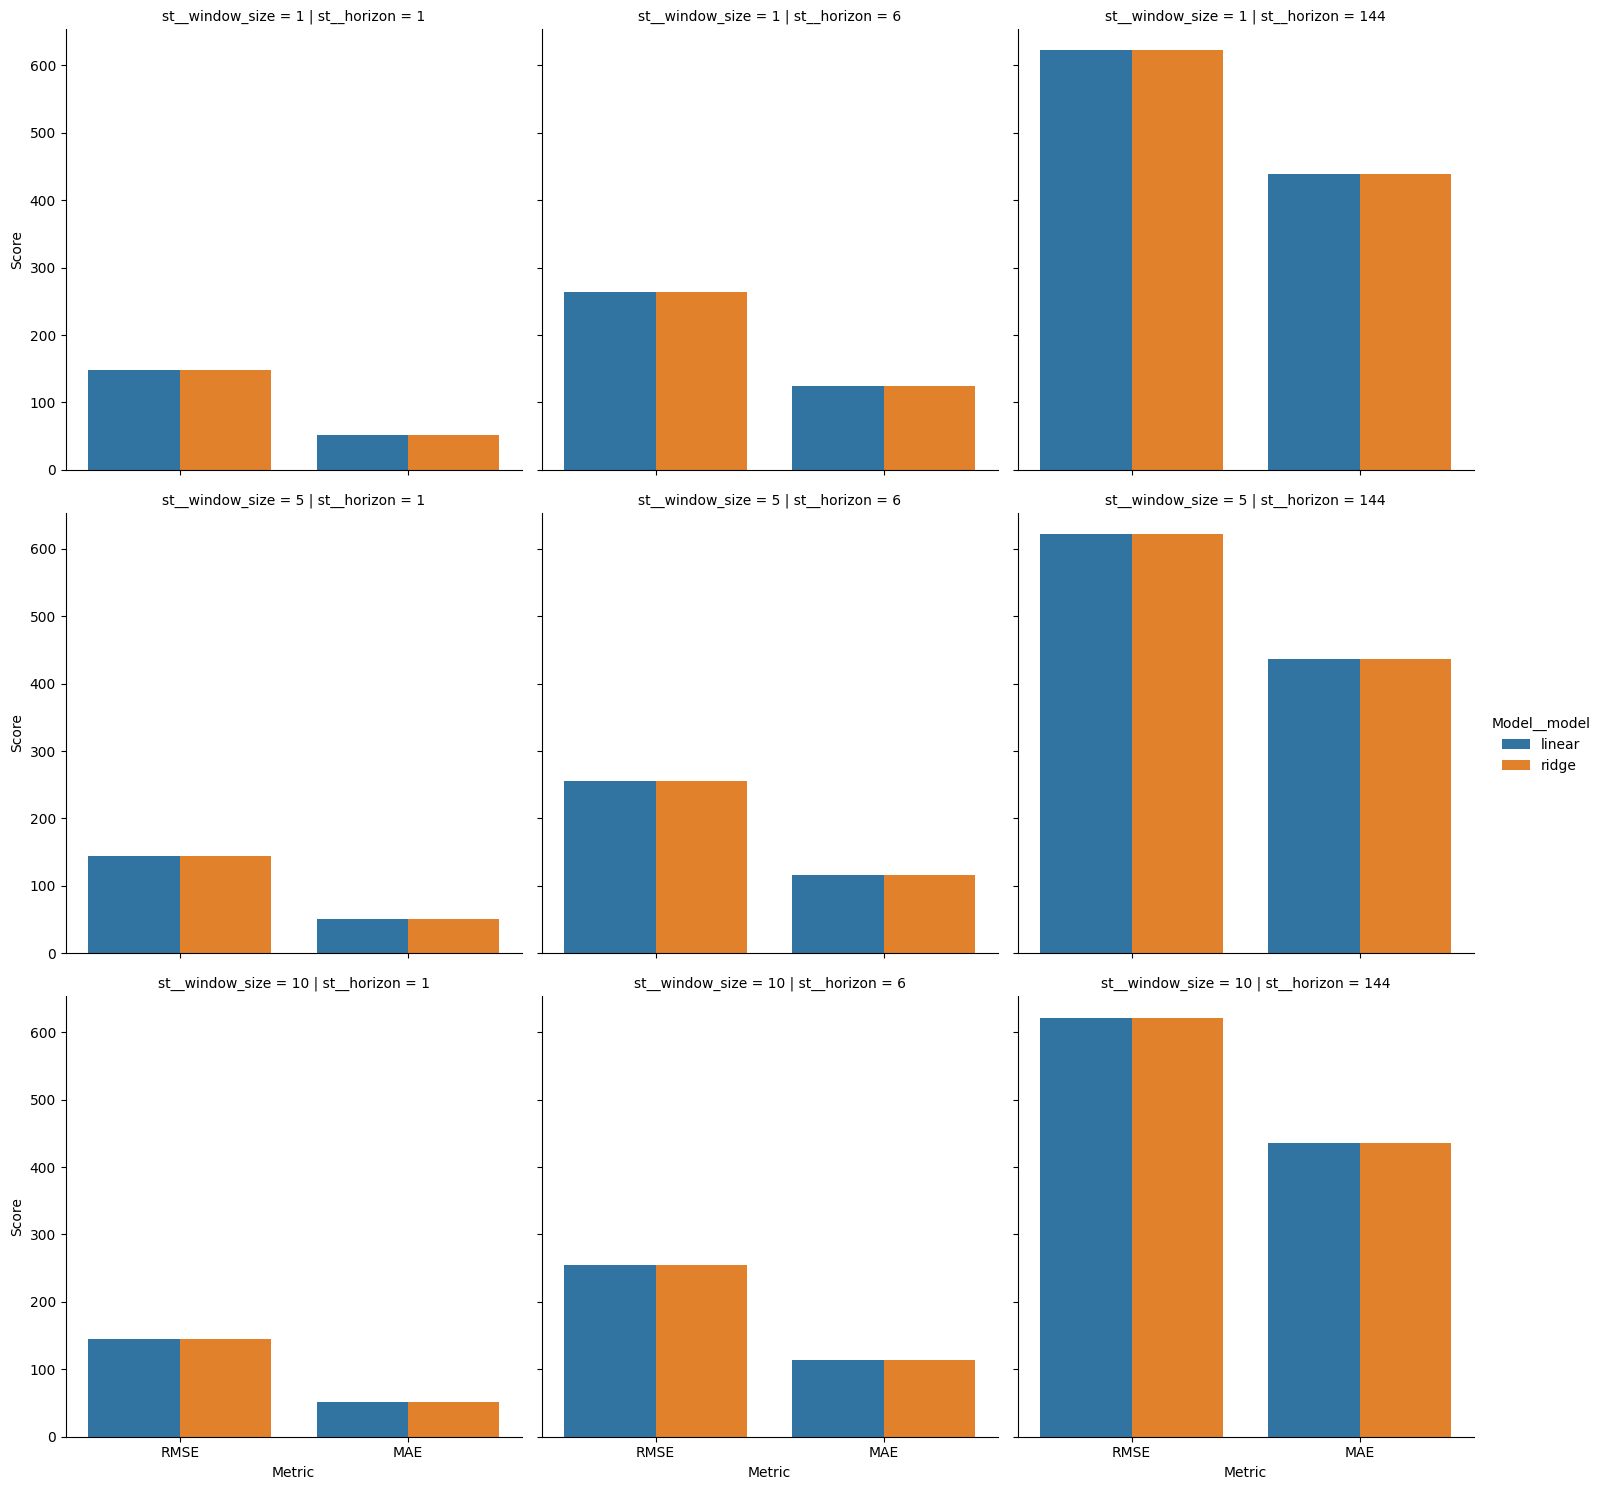

In [12]:
vis.plot_gridsearch(results_df = grid_search_lr.results, hue = "Model__model", col="st__horizon", row="st__window_size")

In [13]:
grid_search_lr.best_params

st__horizon
1         (0.001, ridge, 1, 10)
6         (0.001, ridge, 6, 10)
144    (0.001, linear, 144, 10)
Name: RMSE, dtype: object

In [14]:
grid_search_lr.best_models

[Pipeline(steps=[('normalizer', Normalizer()),
                 ('st', SupervisedTransformer(window_size=10)),
                 ('Model', Regression(alpha=0.001, model=Ridge()))]),
 Pipeline(steps=[('normalizer', Normalizer()),
                 ('st', SupervisedTransformer(horizon=6, window_size=10)),
                 ('Model', Regression(alpha=0.001, model=Ridge()))]),
 Pipeline(steps=[('normalizer', Normalizer()),
                 ('st', SupervisedTransformer(horizon=144, window_size=10)),
                 ('Model', Regression(alpha=0.001, model=LinearRegression()))])]

In [15]:
# delete keys of param_grid that is specific to the model
del param_grid["Model__model"]
del param_grid["Model__alpha"]
param_grid

{'st__window_size': [1, 5, 10], 'st__horizon': [1, 6, 144]}